In [1]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
from collections import OrderedDict
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import os
import functools
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm.notebook import tqdm
import matplotlib.cm as cm
from anndata import AnnData
import itertools as it
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.sparse import vstack
import time
import torch.nn as nn
import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans
import torch
from torch.nn import functional as F
import torch.nn.functional as F

In [46]:
### Read in scATAC data 
scatac=sc.read_h5ad("/home/estelle860530/Getz_lab/data/scAtac_label_mit.h5ad")

sample2response={'620':'PD', 
                 '776':'PD',
                 '856_A':'PD',
                 '856_B':'PD',
                 '1224_post_Ft':'PD', 
                 '1224_post_Cln':'PD',
                 '509_2':'R',
                 '509_post':'R',
                 '1227':'R',
                 '1009':'R',
                 '1130':'R'}

scatac.obs['response']=scatac.obs['orig.ident'].map(sample2response)

scatac.obs['dbscan']=np.zeros(scatac.X.shape[0])

for ind, name in enumerate(Counter(scatac.obs['predicted.id'])):
    if name == "malignant":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=1
    if name == "Endothelial":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=2
    if name == "T":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=3
    if name == "Macrophage":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=4
    if name == "B":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=5
    if name == "CAF":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=6
    if name == "Dendritic":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=7
    if name == "Plasma B":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=8
    if name == "NK":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=9

scatac.obs['dbscan'] = scatac.obs['dbscan'].astype('int32')

num2name={1:'Malignant',2:'Endothelial',3:'T cell', 4:'Macrophage',
          5:'B cell',6:'CAF',7:'Dendritic',8:'Plasma B', 9:'NK'}

scatac.obs['annotated_celltype']=scatac.obs['dbscan'].map(num2name)

#sc.pl.umap(scatac, color=['dbscan'], legend_loc="on data")

### Annotation file: 

Column names [0,1,2,3,4]: MARS probablistic naming from the 5th probable to the 1st probable names for that cluster

Column names [0.1, 0.2,0.3,0.4] : Probablisties for that cluster be named with the corresponding cell label 

**Visualize with the original scATAC UMAP embedding but labeled with MARS cell types**

### Visualize MARS probablistic naming train on: Colon Granular data 

In [101]:
##Read in annotation dataframe
anno = pd.read_csv("colon_anno.csv")

##Rename cell label in annotation
anno['index_x'] = anno['index_x'].replace('-Unannotated','', regex=True)
anno.index = anno.index_x

##Match annotation cell name to scATAC data 
anno = anno.reindex(scatac.obs.index)

##Make categorical for plotting 
anno['MARS_category']=pd.Categorical(anno.MARS_labels)

##Reset scatac adata observation table to annotation 
scatac.obs = anno

In [94]:
scatac.obs

,Unnamed: 0,index_x,truth_labels,MARS_labels,experiment,label_name,index_y,0,1,2,3,4,0.1,1.1,2.1,3.1,4.1,MARS_category
pt620_AAACGAAGTCGACTGC-1,11,pt620_AAACGAAGTCGACTGC-1,3,2,Unannotated,T cell,2,CD4+ Memory,ILCs,Cycling T,MT-hi,Plasma,0.071224,0.077674,0.085488,0.093069,0.099762,2
pt620_AAACTCGTCGCTCTAC-1,8444,pt620_AAACTCGTCGCTCTAC-1,3,2,Unannotated,T cell,2,CD4+ Memory,ILCs,Cycling T,MT-hi,Plasma,0.071224,0.077674,0.085488,0.093069,0.099762,2
pt620_AAATGCCCAACTACTG-1,11491,pt620_AAATGCCCAACTACTG-1,1,2,Unannotated,Malignant,2,CD4+ Memory,ILCs,Cycling T,MT-hi,Plasma,0.071224,0.077674,0.085488,0.093069,0.099762,2
pt620_AAATGCCCACCTGGTG-1,5255,pt620_AAATGCCCACCTGGTG-1,3,2,Unannotated,T cell,2,CD4+ Memory,ILCs,Cycling T,MT-hi,Plasma,0.071224,0.077674,0.085488,0.093069,0.099762,2
pt620_AACAGTCGTTGGCTAT-1,1361,pt620_AACAGTCGTTGGCTAT-1,3,2,Unannotated,T cell,2,CD4+ Memory,ILCs,Cycling T,MT-hi,Plasma,0.071224,0.077674,0.085488,0.093069,0.099762,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pt509_2_TTTGTGTCATCATCGA-1,32172,pt509_2_TTTGTGTCATCATCGA-1,5,4,Unannotated,B cell,4,ILCs,Plasma,Cycling B,GC,Follicular,0.003397,0.004079,0.095476,0.136616,0.746155,4
pt509_2_TTTGTGTGTAACGGCA-1,9832,pt509_2_TTTGTGTGTAACGGCA-1,3,2,Unannotated,T cell,2,CD4+ Memory,ILCs,Cycling T,MT-hi,Plasma,0.071224,0.077674,0.085488,0.093069,0.099762,2
pt509_2_TTTGTGTGTAGCAGGT-1,38821,pt509_2_TTTGTGTGTAGCAGGT-1,3,10,Unannotated,T cell,10,ILCs,CD4+ Memory,CD4+ Activated Fos-hi,CD4+ Activated Fos-lo,Tregs,0.111735,0.122477,0.123315,0.131710,0.148806,10
pt509_2_TTTGTGTGTTAGGAAT-1,32575,pt509_2_TTTGTGTGTTAGGAAT-1,5,4,Unannotated,B cell,4,ILCs,Plasma,Cycling B,GC,Follicular,0.003397,0.004079,0.095476,0.136616,0.746155,4


In [102]:
colon_df = anno.copy()

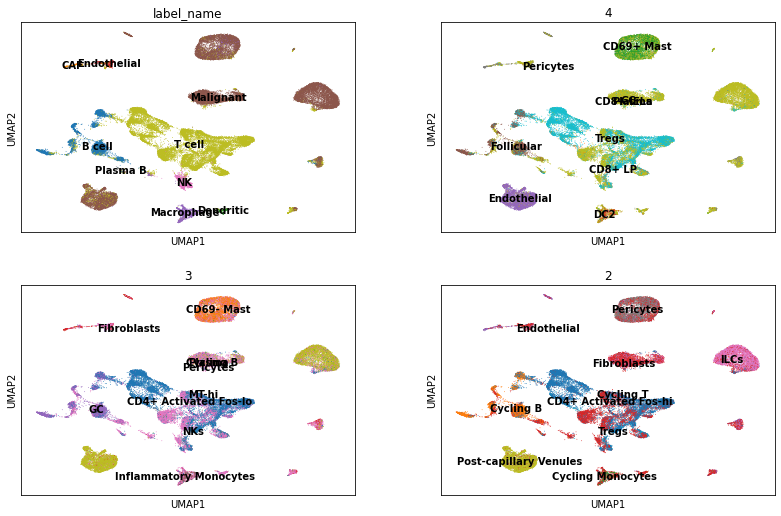

In [91]:
sc.pl.umap(scatac, color=['label_name', '4','3','2'],ncols =2 ,legend_loc="on data" )

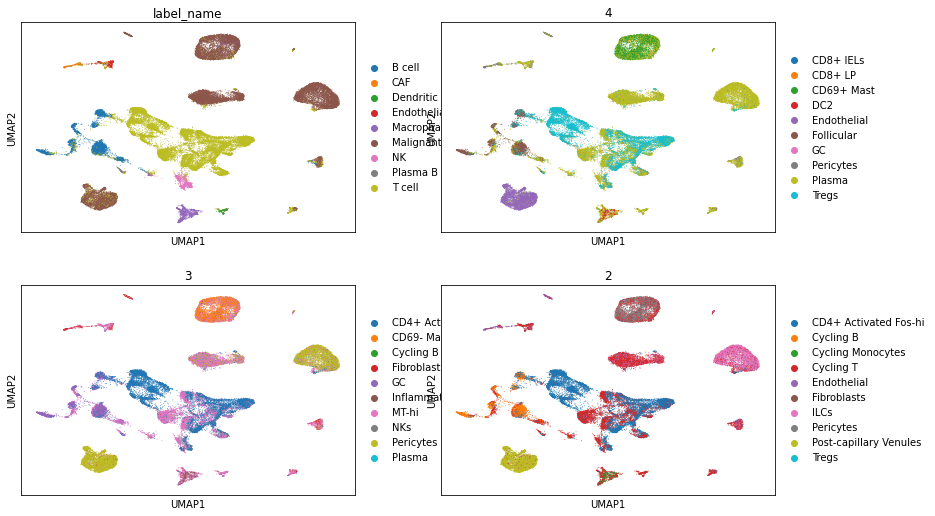

In [92]:
sc.pl.umap(scatac, color=['label_name', '4','3','2'],ncols =2  )

In [43]:
malignant = anno.loc[anno['label_name']=="Malignant", ['MARS_labels','4','4.1']] 
bcell = anno.loc[anno['label_name']=="B cell", ['4','4.1']] 
tcell = anno.loc[anno['label_name']=="T cell", ['4','4.1']] 
caf = anno.loc[anno['label_name']=="CAF", ['4','4.1']] 

df = pd.DataFrame.from_dict(Counter(malignant.MARS_labels), orient="index").reset_index()
df.columns=['MARS_labels','Counts']
df['Percentage'] = df['Counts']/np.sum(df.Counts)*100
df = df.sort_values(by="Counts", ascending=False)
df['cumsum']=np.cumsum(df['Percentage'])
df

,MARS_labels,Counts,Percentage,cumsum
0,2,6342,32.499744,32.499744
2,7,5051,25.883981,58.383725
7,6,3584,18.366301,76.750026
3,5,3220,16.500974,93.250999
5,3,682,3.494927,96.745926
1,1,233,1.194015,97.939941
8,0,220,1.127396,99.067336
12,12,77,0.394589,99.461925
11,9,59,0.302347,99.764272
9,10,37,0.189607,99.953879


### Visualize MARS probablistic naming train on: Colon broad category data

In [112]:
##Read in annotation dataframe
anno = pd.read_csv("colon_broad_anno.csv")

##Rename cell label in annotation
anno['index_x'] = anno['index_x'].replace('-Unannotated','', regex=True)
anno.index = anno.index_x

##Match annotation cell name to scATAC data 
anno = anno.reindex(scatac.obs.index)

##Make categorical for plotting 
anno['MARS_category']=pd.Categorical(anno.MARS_labels)

##Reset scatac adata observation table to annotation 
scatac.obs = anno

scatac.obs['label_name'] = colon_df.label_name

... storing 'index_x' as categorical
... storing 'experiment' as categorical
... storing '0' as categorical
... storing '1' as categorical
... storing '2' as categorical
... storing '3' as categorical
... storing '4' as categorical
... storing 'label_name' as categorical


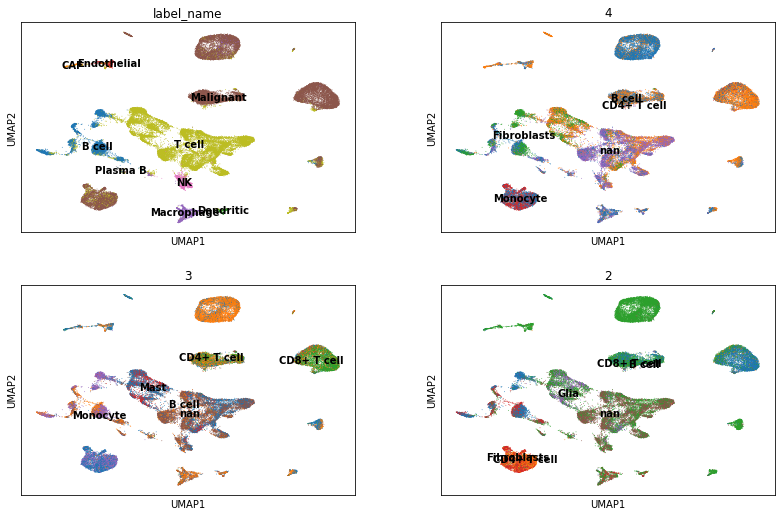

In [113]:
sc.pl.umap(scatac, color=['label_name', '4','3','2'],ncols =2 ,legend_loc="on data" )

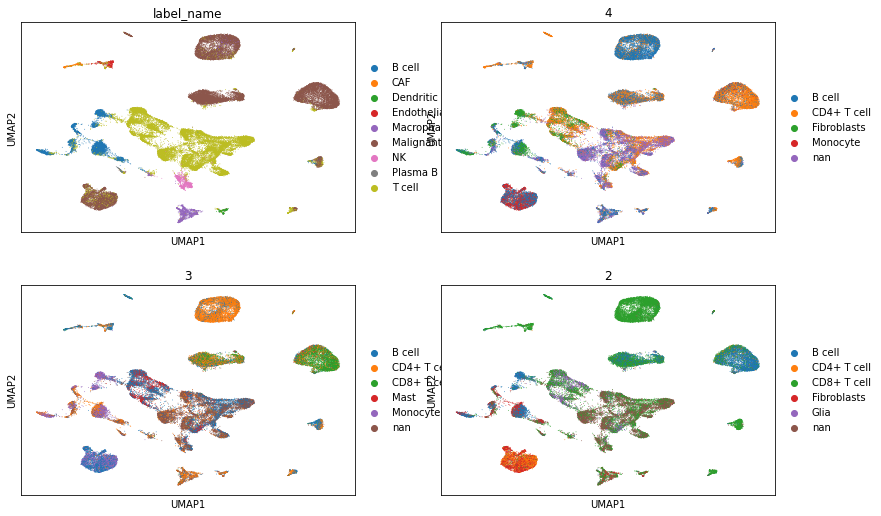

In [114]:
sc.pl.umap(scatac, color=['label_name', '4','3','2'],ncols =2  )

### Visualize MARS probablistic naming train on: Seurat V4 PBMC Cell type level 2 

In [103]:
##Read in annotation dataframe
anno = pd.read_csv("seurat_level2_anno.csv")

##Rename cell label in annotation
anno['index_x'] = anno['index_x'].replace('-Unannotated','', regex=True)
anno.index = anno.index_x

##Match annotation cell name to scATAC data 
anno = anno.reindex(scatac.obs.index)

##Make categorical for plotting 
anno['MARS_category']=pd.Categorical(anno.MARS_labels)

##Reset scatac adata observation table to annotation 
scatac.obs = anno

In [104]:
scatac.obs['label_name'] = colon_df.label_name

In [105]:
scatac.obs

,Unnamed: 0,index_x,truth_labels,MARS_labels,experiment,index_y,0,1,2,3,4,0.1,1.1,2.1,3.1,4.1,MARS_category,label_name
pt620_AAACGAAGTCGACTGC-1,23881,pt620_AAACGAAGTCGACTGC-1,3,12,Unannotated,12,Treg,CD4 TEM,CD4 CTL,CD8 TEM,gdT,0.080695,0.082701,0.093959,0.094841,0.097997,12,T cell
pt620_AAACTCGTCGCTCTAC-1,6449,pt620_AAACTCGTCGCTCTAC-1,3,9,Unannotated,9,CD8 Naive,dnT,CD8 Proliferating,CD4 Proliferating,ILC,0.055396,0.056199,0.064263,0.084260,0.161227,9,T cell
pt620_AAATGCCCAACTACTG-1,15418,pt620_AAATGCCCAACTACTG-1,1,11,Unannotated,11,CD4 Proliferating,NK_CD56bright,CD8 Naive,NK Proliferating,ILC,0.051393,0.053849,0.064895,0.121483,0.152139,11,Malignant
pt620_AAATGCCCACCTGGTG-1,1878,pt620_AAATGCCCACCTGGTG-1,3,9,Unannotated,9,CD8 Naive,dnT,CD8 Proliferating,CD4 Proliferating,ILC,0.055396,0.056199,0.064263,0.084260,0.161227,9,T cell
pt620_AACAGTCGTTGGCTAT-1,42991,pt620_AACAGTCGTTGGCTAT-1,3,3,Unannotated,3,ILC,CD8 Proliferating,cDC2,CD14 Mono,Doublet,0.046898,0.056480,0.149417,0.150109,0.168191,3,T cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pt509_2_TTTGTGTCATCATCGA-1,32776,pt509_2_TTTGTGTCATCATCGA-1,5,0,Unannotated,0,CD16 Mono,B memory,B intermediate,CD14 Mono,B naive,0.017039,0.025097,0.038955,0.139926,0.744013,0,B cell
pt509_2_TTTGTGTGTAACGGCA-1,18811,pt509_2_TTTGTGTGTAACGGCA-1,3,12,Unannotated,12,Treg,CD4 TEM,CD4 CTL,CD8 TEM,gdT,0.080695,0.082701,0.093959,0.094841,0.097997,12,T cell
pt509_2_TTTGTGTGTAGCAGGT-1,35158,pt509_2_TTTGTGTGTAGCAGGT-1,3,8,Unannotated,8,dnT,CD8 TEM,CD4 CTL,Treg,CD14 Mono,0.029036,0.034269,0.034467,0.059249,0.734222,8,T cell
pt509_2_TTTGTGTGTTAGGAAT-1,42652,pt509_2_TTTGTGTGTTAGGAAT-1,5,2,Unannotated,2,B memory,CD16 Mono,B intermediate,CD14 Mono,B naive,0.014622,0.015285,0.021901,0.226418,0.712858,2,B cell


... storing 'experiment' as categorical
... storing '0' as categorical
... storing '1' as categorical
... storing '2' as categorical
... storing '3' as categorical
... storing '4' as categorical
... storing 'label_name' as categorical


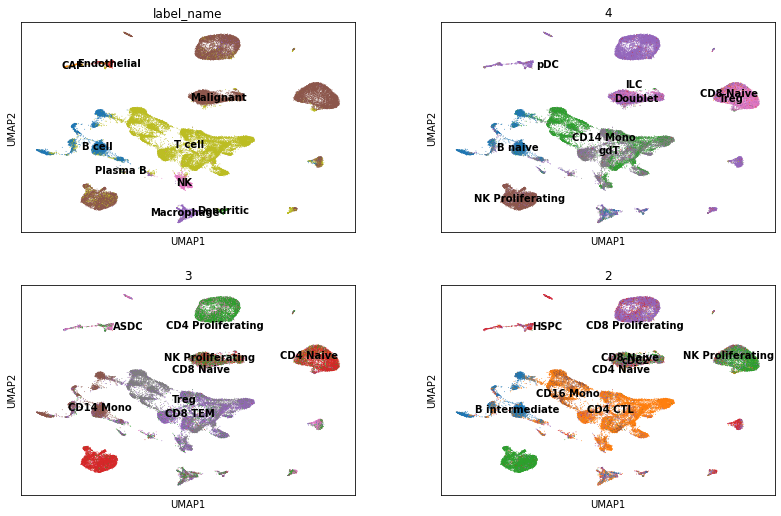

In [106]:
sc.pl.umap(scatac, color=['label_name', '4','3','2'],ncols =2 ,legend_loc="on data" )

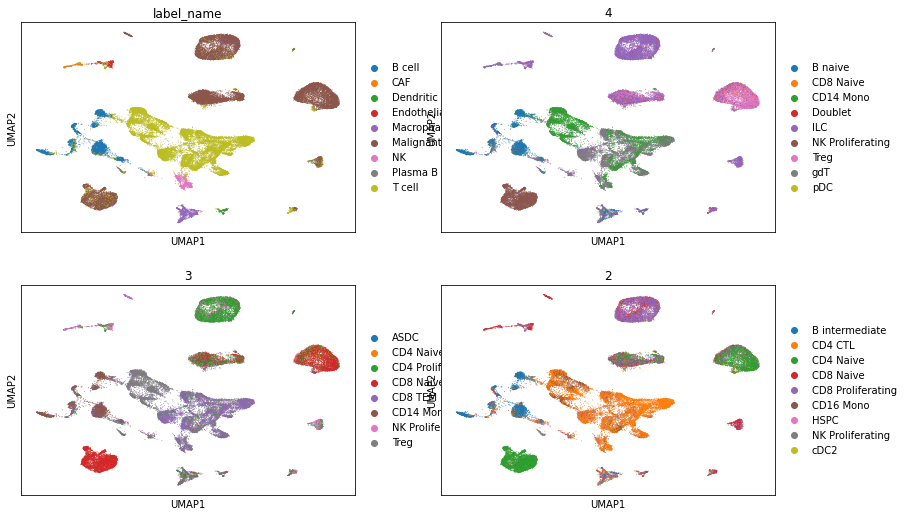

In [107]:
sc.pl.umap(scatac, color=['label_name', '4','3','2'],ncols =2 )

#### Visualize MARS probablistic naming train on: Colon Granular set + Seurat V4 PBMC Cell type level 2

In [ ]:
##Read in annotation dataframe
anno = pd.read_csv("colon_seurat_anno.csv")

##Rename cell label in annotation
anno['index_x'] = anno['index_x'].replace('-Unannotated','', regex=True)
anno.index = anno.index_x

##Match annotation cell name to scATAC data 
anno = anno.reindex(scatac.obs.index)

##Make categorical for plotting 
anno['MARS_category']=pd.Categorical(anno.MARS_labels)

##Reset scatac adata observation table to annotation 
scatac.obs = anno

In [ ]:
sc.pl.umap(scatac, color=['label_name', '4','3','2'],ncols =2 ,legend_loc="on data" )

In [ ]:
sc.pl.umap(scatac, color=['label_name', '4','3','2'],ncols =2 )